<a href="https://colab.research.google.com/github/SamAbr/FPL-Squad-Selection/blob/main/FPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

## Description

This section collects live Fantasy Premier League (FPL) data using the **official FPL public API**.  
The API provides comprehensive, real-time information about players, teams, fixtures, and gameweeks, which will form the foundation for building an **FPL team selection and performance optimization model**.

The goal of this step is to load and explore key FPL data tables directly into memory as **Pandas DataFrames**, which will later be used for data analysis, feature engineering, and optimization.

---

## Data Source

**API Base URL:**  
`https://fantasy.premierleague.com/api/`

**Main Endpoints Used:**
| Endpoint | Description |
|-----------|--------------|
| `/bootstrap-static/` | Returns metadata on all players, teams, and gameweeks. |
| `/fixtures/` | Provides all Premier League fixtures and difficulty ratings. |

The API is open and does not require authentication.  
Data is collected using simple HTTP GET requests via Python’s `requests` library.

---

## Collected DataFrames

| DataFrame | Description | Key Columns |
|------------|--------------|--------------|
| `players_df` | Contains player-level statistics and attributes. | `web_name`, `team`, `element_type`, `price_m`, `form`, `total_points`, `ict_index` |
| `teams_df` | Contains information about all Premier League teams. | `id`, `name`, `strength_overall_home`, `strength_overall_away` |
| `positions_df` | Provides mappings for player positions. | `id`, `singular_name` (e.g., Goalkeeper, Defender) |
| `fixtures_df` | Contains fixture list with home/away teams and difficulty ratings. | `event`, `team_h`, `team_a`, `team_h_difficulty`, `team_a_difficulty` |
| `events_df` | Stores metadata for each gameweek (past and upcoming). | `id`, `name`, `deadline_time`, `finished` |

---

## Technical Notes

- Data is fetched using HTTPS requests directly from the official FPL API.
- Player costs (`now_cost`) are stored in tenths of a million; converted to millions (`price_m`) for clarity.
- All data is stored **in-memory** as Pandas DataFrames (no CSV export required).
- API is updated daily by the FPL system, reflecting the latest prices, points, and forms.
- The script includes a short delay between requests to prevent overloading the server.


In [1]:
# Loading important libraries
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

BASE = "https://fantasy.premierleague.com/api"

def fetch_json(url, sleep=0.5):
    """Fetch JSON from FPL API with a short polite delay."""
    r = requests.get(url, headers={"User-Agent": "colab-fpl-analyzer/1.0"})
    r.raise_for_status()
    time.sleep(sleep)
    return r.json()

# Fetch bootstrap data
bootstrap = fetch_json(f"{BASE}/bootstrap-static/")

# Extract useful tables
players_df = pd.DataFrame(bootstrap["elements"])
teams_df = pd.DataFrame(bootstrap["teams"])
positions_df = pd.DataFrame(bootstrap["element_types"])
events_df = pd.DataFrame(bootstrap["events"])

# Convert cost units (tenths of millions → millions)
players_df["price_m"] = players_df["now_cost"] / 10

# Keep only important columns
keep_cols = [
    "id","web_name","team","element_type","price_m",
    "total_points","minutes","goals_scored","assists",
    "clean_sheets","form","ict_index","selected_by_percent", "status", "photo"
]
players_df = players_df[keep_cols]

# Fetch fixtures
fixtures_df = pd.DataFrame(fetch_json(f"{BASE}/fixtures/"))

print("✅ Data loaded into memory successfully.")
print("Players shape:", players_df.shape)
print("Teams shape:", teams_df.shape)
print("Fixtures shape:", fixtures_df.shape)

# Display a quick preview
players_df.head()

✅ Data loaded into memory successfully.
Players shape: (748, 15)
Teams shape: (20, 21)
Fixtures shape: (380, 17)


,id,web_name,team,element_type,price_m,total_points,minutes,goals_scored,assists,clean_sheets,form,ict_index,selected_by_percent,status,photo
0,1,Raya,1,1,5.8,52,900,0,0,7,6.0,16.8,31.7,a,154561.jpg
1,2,Arrizabalaga,1,1,4.2,0,0,0,0,0,0.0,0.0,0.5,a,109745.jpg
2,3,Hein,1,1,4.0,0,0,0,0,0,0.0,0.0,0.3,u,463748.jpg
3,4,Setford,1,1,4.0,0,0,0,0,0,0.0,0.0,0.2,a,551221.jpg
4,5,Gabriel,1,2,6.6,80,900,1,2,7,11.0,42.8,41.8,a,226597.jpg


# Data Cleaning and Preprocessing

In this step, we clean the `players_features_df` dataset to prepare it for analysis.  
This dataset already includes important FPL performance indicators such as:
- `total_points`, `minutes`, `form`, and `ict_index` for performance tracking.  
- `price_m`, `points_per_million`, and `value_index` for value-based analysis.  
- `team_name` and `position` for grouping and visualization.  

We will:
1. Keep the most relevant columns.
2. Ensure correct data types.
3. Rename and reorder columns for clarity.

## Data Wrangling Function

To ensure reproducibility and maintain a clean workflow, the data cleaning and preprocessing steps are wrapped in a single function called `clean_fpl_data()`.  

This function:
1. Selects the most relevant columns from the raw dataset.  
2. Converts numeric fields to the proper data type.  
3. Handles missing values by filling them with zero.  
4. Returns a clean, analysis-ready DataFrame.


In [2]:
def clean_fpl_data(df, teams_df, positions_df) -> pd.DataFrame:
    """
    Cleans and preprocesses the Fantasy Premier League (FPL) player dataset.

    """
    # Convert form to numeric
    df["form_numeric"] = df["form"].astype(float)

    # Compute cost-effectiveness
    df["points_per_million"] = df["total_points"] / df["price_m"]

    # Merge readable team names
    df = df.merge(
        teams_df[["id", "name"]],
        left_on="team",
        right_on="id",
        how="left"
    ).rename(columns={"name": "team_name"}).drop(columns=["id_y"]).rename(columns={"id_x": "id"})

    # Merge position names
    df = df.merge(
        positions_df[["id", "singular_name"]],
        left_on="element_type",
        right_on="id",
        how="left"
    ).rename(columns={"singular_name": "position"}).drop(columns=["id_y"]).rename(columns={"id_x": "id"})

    # Create a simple value metric
    df["value_index"] = df["form_numeric"] * df["points_per_million"]


    # Select relevant columns
    cols = [
        'web_name', 'team_name', 'position',
        'price_m', 'total_points', 'minutes',
        'goals_scored', 'assists', 'clean_sheets',
        'form', 'ict_index', 'selected_by_percent',
        'form_numeric', 'points_per_million', 'value_index', 'status', 'photo'
    ]

    # Keep only available ones (safe selection)
    cols = [c for c in cols if c in df.columns]
    fpl_df = df[cols].copy()

    # Rename columns for consistency
    rename_map = {
        'web_name': 'player_name',
        'team_name': 'team',
        'position': 'position',
        'price_m': 'price_million'
    }
    fpl_df.rename(columns=rename_map, inplace=True)

    # Convert numeric columns
    numeric_cols = [
        'price_million', 'total_points', 'minutes', 'goals_scored',
        'assists', 'clean_sheets', 'form', 'ict_index',
        'selected_by_percent', 'form_numeric', 'points_per_million', 'value_index'
    ]
    numeric_cols = [c for c in numeric_cols if c in fpl_df.columns]
    fpl_df[numeric_cols] = fpl_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Fill missing values
    fpl_df.fillna(0, inplace=True)

    # Reorder for readability
    ordered_cols = [
        'player_name', 'team', 'position', 'price_million',
        'total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
        'form', 'ict_index', 'selected_by_percent', 'points_per_million', 'value_index', 'status', 'photo'
    ]
    ordered_cols = [c for c in ordered_cols if c in fpl_df.columns]
    fpl_df = fpl_df[ordered_cols]

    print(f"✅ Cleaned dataset ready: {fpl_df.shape[0]} players × {fpl_df.shape[1]} columns")
    return fpl_df

In [3]:
fpl_df = clean_fpl_data(players_df, teams_df, positions_df)
fpl_df.head()

✅ Cleaned dataset ready: 748 players × 16 columns


,player_name,team,position,price_million,total_points,minutes,goals_scored,assists,clean_sheets,form,ict_index,selected_by_percent,points_per_million,value_index,status,photo
0,Raya,Arsenal,Goalkeeper,5.8,52,900,0,0,7,6.0,16.8,31.7,8.965517,53.793103,a,154561.jpg
1,Arrizabalaga,Arsenal,Goalkeeper,4.2,0,0,0,0,0,0.0,0.0,0.5,0.000000,0.000000,a,109745.jpg
2,Hein,Arsenal,Goalkeeper,4.0,0,0,0,0,0,0.0,0.0,0.3,0.000000,0.000000,u,463748.jpg
3,Setford,Arsenal,Goalkeeper,4.0,0,0,0,0,0,0.0,0.0,0.2,0.000000,0.000000,a,551221.jpg
4,Gabriel,Arsenal,Defender,6.6,80,900,1,2,7,11.0,42.8,41.8,12.121212,133.333333,a,226597.jpg


# Exploratory Data Analysis

In this step, we explore patterns and trends in the Fantasy Premier League dataset.  
Our objectives are to:
1. Understand the distribution of player points and prices.  
2. Identify top-performing players overall and by position.  
3. Analyze the relationship between cost and total points.  
4. Evaluate which teams provide the best value-for-money players.  

This analysis provides the foundation for feature engineering and model-based team optimization in later steps.

In [4]:
# General style
sns.set(style="whitegrid", palette="muted")

# 1️⃣ Basic overview
print("Dataset shape:", fpl_df.shape)
print("\nColumns:", fpl_df.columns.tolist())
print("\nSummary statistics:")
display(fpl_df.describe())

Dataset shape: (748, 16)

Columns: ['player_name', 'team', 'position', 'price_million', 'total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'form', 'ict_index', 'selected_by_percent', 'points_per_million', 'value_index', 'status', 'photo']

Summary statistics:


,price_million,total_points,minutes,goals_scored,assists,clean_sheets,form,ict_index,selected_by_percent,points_per_million,value_index
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,4.975000,12.109626,263.227273,0.342246,0.328877,0.851604,1.213102,12.925267,2.001872,2.248248,7.122741
std,1.090683,15.835542,316.364488,0.951561,0.741842,1.382879,1.879635,17.593611,6.098563,2.853904,14.581784
min,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-2.558140
25%,4.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
50%,4.800000,4.000000,89.500000,0.000000,0.000000,0.000000,0.000000,3.900000,0.200000,0.833333,0.000000
75%,5.400000,20.000000,540.000000,0.000000,0.000000,1.000000,2.000000,22.000000,0.900000,3.872614,6.703125
max,14.800000,98.000000,900.000000,13.000000,5.000000,7.000000,11.000000,116.000000,69.900000,12.800000,133.333333


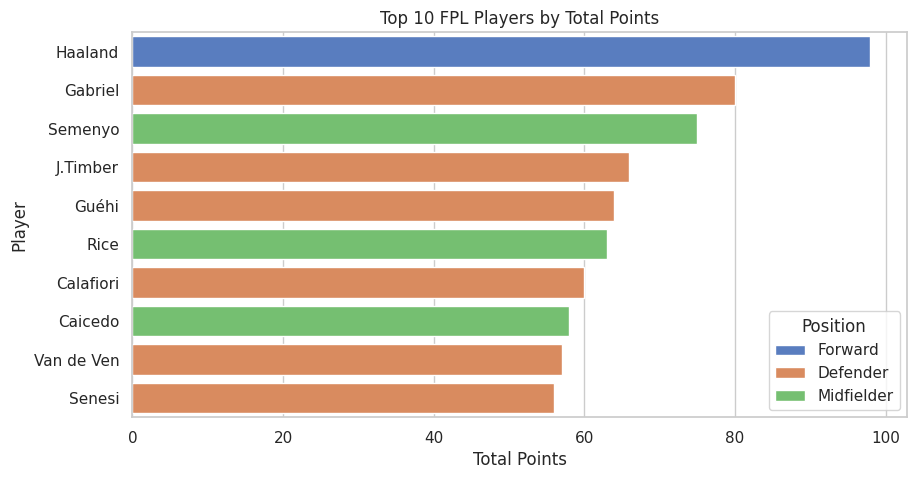

In [5]:
# 2️⃣ Top 10 players by total points
top_players = fpl_df.sort_values('total_points', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(data=top_players, x='total_points', y='player_name', hue='position', dodge=False)
plt.title("Top 10 FPL Players by Total Points")
plt.xlabel("Total Points")
plt.ylabel("Player")
plt.legend(title="Position")
plt.show();

## Top 10 FPL Players by Total Points - Insights

*   **Haaland is the clear top performer**, significantly outperforming all other players with close to 100 total points.
*   **Forwards and Defenders dominate the top 10**, with 7 of the 10 spots (4 Forwards, 3 Defenders).
*   **Midfielders are severely underrepresented**, with only 1 player (Semenyo) making the list.
*   **Gabriel is the highest-scoring defender**, ranking second only to Haaland overall.
*   There is a **significant performance gap** between the top 2 players (Haaland, Gabriel) and the rest of the list.
* **Arsenal players are dominating the list**, with 4 of the top 10 players (Gabriel, J. Timber, Rice, and Calafiori*).

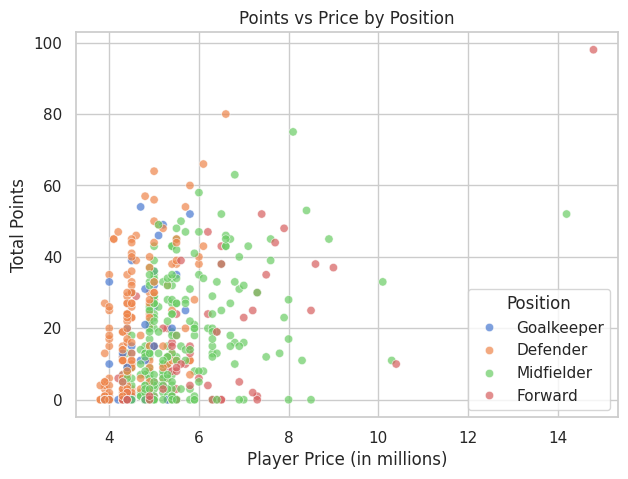

In [6]:
# 3️⃣ Points vs Price scatter
plt.figure(figsize=(7,5))
sns.scatterplot(data=fpl_df, x='price_million', y='total_points', hue='position', alpha=0.7)
plt.title("Points vs Price by Position")
plt.xlabel("Player Price (in millions)")
plt.ylabel("Total Points")
plt.legend(title="Position")
plt.show()

## Points vs Price by Position - Insights

*   **Forwards offer the highest points ceiling**, with the top scorers significantly outperforming all other positions.
*   **Defenders provide the best value**, clustering in the high-points, low-to-mid price range, indicating strong returns for their cost.
*   **Midfielders show the widest performance variance**, ranging from low-value, high-cost players to some of the best value picks in the game.
*   **Goalkeepers are tightly grouped**, showing minimal point difference between the cheapest and most expensive options, making budget picks optimal.

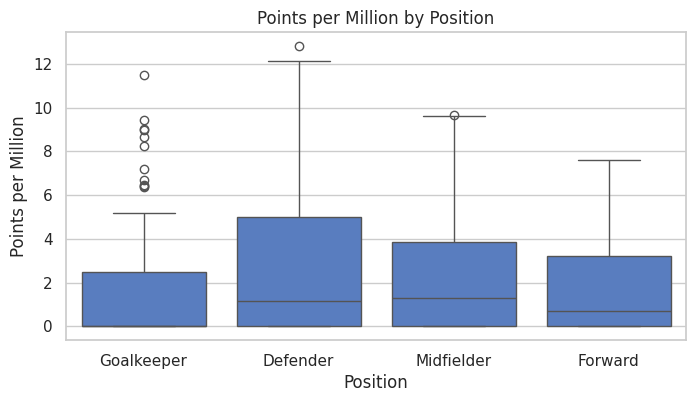

In [7]:
# 4️⃣ Value for money distribution (Points per Million)

# Display top 10
fpl_df.head(10)[["team", "position", "price_million", "form", "points_per_million", "value_index"]]
plt.figure(figsize=(8,4))
sns.boxplot(data=fpl_df, x='position', y='points_per_million')
plt.title("Points per Million by Position")
plt.xlabel("Position")
plt.ylabel("Points per Million")
plt.show()

## Points per Million by Position - Insights

*   **Defenders provide the best value**, offering the highest points return per million spent by a significant margin.
*   **Goalkeepers are the second-most efficient position**, making them a key target for budget-friendly, high-value picks.
*   **Midfielders and Forwards offer lower value**, with their high price tags not being justified by a proportional points return in this metric.
*   **Team budget allocation strategy is clear**: investing heavily in the defense and goalkeeper slots provides the most efficient return on investment.

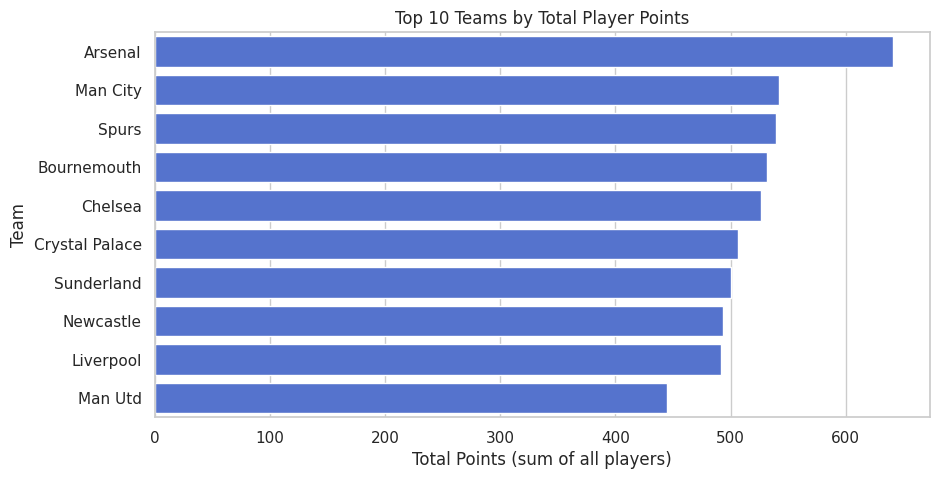

In [8]:
# 5️⃣ Team-wise total points
team_points = fpl_df.groupby('team')['total_points'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=team_points.values, y=team_points.index, color="royalblue")
plt.title("Top 10 Teams by Total Player Points")
plt.xlabel("Total Points (sum of all players)")
plt.ylabel("Team")
plt.show()

## Top 10 Teams by Total Player Points - Insights

*   **Arsenal is the dominant team**, accumulating the highest total points by a significant margin, well ahead of second-place Man City.
*   **The "Big Six" are mostly represented**, with Arsenal, Man City, Spurs, Chelsea, Liverpool, and Man Utd all in the top 10.
*   **Bournemouth is a standout performer**, ranking 4th and punching above their weight compared to traditional top clubs.
*   **Sunderland's presence is a major surprise**, significantly outperforming expectations by appearing in this elite company.
*   **A clear "top two" exists**, with Arsenal and Man City forming a distinct tier above all other teams.

# Feature Engineering

Feature Engineering involves creating new variables from existing data to enhance the predictive or analytical power of the dataset.

In the context of Fantasy Premier League (FPL), we aim to design metrics that reflect:
- Player performance consistency
- Value-for-money
- Recent form impact
- Contribution efficiency (points per minute or per million cost)

These engineered features will later be used to optimize team selection and budget allocation.

In [9]:
from ast import type_ignore
# Copy dataframe to avoid overwriting
fpl_features = fpl_df.copy()

# 1️⃣ Efficiency: Points per 90 minutes (normalized by playtime)
fpl_features['points_per_90'] = fpl_features['total_points'] / (fpl_features['minutes'] / 90)
fpl_features['points_per_90'].fillna(0, inplace=True)

# 2️⃣ Value Efficiency: Points per cost (more granular than points_per_million)
fpl_features['points_per_price'] = fpl_features['total_points'] / fpl_features['price_million']
fpl_features['points_per_price'].replace([float('inf'), -float('inf')], 0, inplace=True)

# 3️⃣ Form-weighted Points (adjusts total points by current form)
fpl_features['form_adjusted_points'] = fpl_features['total_points'] * (fpl_features['form'] / fpl_features['form'].max())

# 4️⃣ Consistency metric: Ratio of total points to matches played (approx.)
fpl_features['consistency_index'] = fpl_features['total_points'] / (fpl_features['minutes'] / 90)
fpl_features['consistency_index'].fillna(0, inplace=True)

# 5️⃣ Normalize points per million and value_index for later ranking
scaler = MinMaxScaler()
for col in ['points_per_million', 'value_index']:
    if col in fpl_features.columns:
        fpl_features[f'{col}_norm'] = scaler.fit_transform(fpl_features[[col]])

# Display the top 10 players by value and performance
display(fpl_features[['player_name', 'team', 'position', 'price_million',
                      'total_points', 'points_per_90', 'points_per_price',
                      'form_adjusted_points', 'value_index_norm']].sort_values(
                      'points_per_90', ascending=False).head(10));

,player_name,team,position,price_million,total_points,points_per_90,points_per_price,form_adjusted_points,value_index_norm
320,Coleman,Everton,Defender,4.3,2,90.0,0.465116,0.000000,0.018825
331,Armstrong,Everton,Midfielder,4.5,1,90.0,0.222222,0.000000,0.018825
375,Kusi-Asare,Fulham,Forward,4.5,1,90.0,0.222222,0.027273,0.019315
281,Sosa,Crystal Palace,Defender,4.9,1,90.0,0.204082,0.027273,0.019275
132,Soler,Bournemouth,Defender,4.0,1,90.0,0.250000,0.000000,0.018825
149,Enes Ünal,Bournemouth,Forward,5.4,1,90.0,0.185185,0.027273,0.019234
310,Canvot,Crystal Palace,Defender,4.5,1,90.0,0.222222,0.027273,0.019315
231,Knight,Brighton,Midfielder,4.5,1,90.0,0.222222,0.027273,0.019315
238,Oriola,Brighton,Midfielder,4.5,1,90.0,0.222222,0.027273,0.019315
614,Neil,Sunderland,Midfielder,4.8,2,90.0,0.416667,0.054545,0.019745


As we can see "Armstrong" is ranked first based on points_per_90 while he has a total point of one because the number of minutes he played are very few.

That’s a common issue when working with ratio-based metrics like `points_per_90` or `points_per_price`:
Players who played only a few minutes but scored or assisted once can have **inflated stats**, making them appear “elite” even though they hardly played.

---

## Filtering for Meaningful Playtime

A solid approach is to only include players who have played a **reasonable amount of minutes**, in our case, **at least half of the maximum minutes** played by any player.

Let’s apply this rule.

---

### Reasoning

If a full-time player played around `max_minutes = 3420` minutes (≈38 matches × 90 mins),  
then “half” means players who played **≥1710 minutes**, roughly **19 full matches**.

That keeps **regular starters** and **meaningful contributors** while removing **statistical outliers**.

In [10]:
# Calculate threshold: half of the maximum minutes played
threshold = fpl_features['minutes'].max() / 2

# Filter players who played at least half of the max minutes
fpl_filtered = fpl_features[fpl_features['minutes'] >= threshold].copy()

print(f"✅ Players considered: {len(fpl_filtered)} out of {len(fpl_features)}")
print(f"🕒 Minimum minutes required: {threshold:.0f}")

# Now re-check the top players by points_per_90 after filtering
fpl_filtered.sort_values('points_per_90', ascending=False).head(10)[
    ['player_name', 'team', 'position', 'minutes', 'points_per_90', 'total_points', 'form']
]

✅ Players considered: 214 out of 748
🕒 Minimum minutes required: 450


,player_name,team,position,minutes,points_per_90,total_points,form
476,Haaland,Man City,Forward,854,10.327869,98,9.3
4,Gabriel,Arsenal,Defender,900,8.000000,80,11.0
7,J.Timber,Arsenal,Defender,791,7.509482,66,6.0
134,Semenyo,Bournemouth,Midfielder,900,7.500000,75,3.0
596,Ballard,Sunderland,Defender,489,7.177914,39,5.3
19,Rice,Arsenal,Midfielder,803,7.061021,63,7.7
6,Calafiori,Arsenal,Defender,766,7.049608,60,6.0
506,Casemiro,Man Utd,Midfielder,546,6.923077,42,9.0
666,P.M.Sarr,Spurs,Midfielder,480,6.562500,35,3.7
433,Gravenberch,Liverpool,Midfielder,691,6.512301,50,4.3


Next, we will get the positional lists. Due to the fact that a specific number of players per each position is allowed in the FPL, we will need to split based on position and rank them.

In [11]:
# Split into positional lists
gk = fpl_filtered[fpl_filtered['position'] == 'Goalkeeper'].sort_values(by='points_per_90', ascending=False)
defenders = fpl_filtered[fpl_filtered['position'] == 'Defender'].sort_values(by='points_per_90', ascending=False)
midfielders = fpl_filtered[fpl_filtered['position'] == 'Midfielder'].sort_values(by='points_per_90', ascending=False)
forwards = fpl_filtered[fpl_filtered['position'] == 'Forward'].sort_values(by='points_per_90', ascending=False)

gk.head()

,player_name,team,position,price_million,total_points,minutes,goals_scored,assists,clean_sheets,form,...,points_per_million,value_index,status,photo,points_per_90,points_per_price,form_adjusted_points,consistency_index,points_per_million_norm,value_index_norm
631,Roefs,Sunderland,Goalkeeper,4.7,54,900,0,0,4,4.3,...,11.489362,49.404255,a,498016.jpg,5.4,11.489362,21.109091,5.4,0.897606,0.382382
0,Raya,Arsenal,Goalkeeper,5.8,52,900,0,0,7,6.0,...,8.965517,53.793103,a,154561.jpg,5.2,8.965517,28.363636,5.2,0.700431,0.414678
522,Pope,Newcastle,Goalkeeper,5.2,49,900,0,1,5,2.7,...,9.423077,25.442308,a,98747.jpg,4.9,9.423077,12.027273,4.9,0.736178,0.206050
638,Vicario,Spurs,Goalkeeper,5.1,46,900,0,0,4,3.7,...,9.019608,33.372549,a,184254.jpg,4.6,9.019608,15.472727,4.6,0.704657,0.264407
119,Petrović,Bournemouth,Goalkeeper,4.5,39,900,0,0,4,4.0,...,8.666667,34.666667,a,457569.jpg,3.9,8.666667,14.181818,3.9,0.677083,0.273930


In [12]:
defenders.head()

,player_name,team,position,price_million,total_points,minutes,goals_scored,assists,clean_sheets,form,...,points_per_million,value_index,status,photo,points_per_90,points_per_price,form_adjusted_points,consistency_index,points_per_million_norm,value_index_norm
4,Gabriel,Arsenal,Defender,6.6,80,900,1,2,7,11.0,...,12.121212,133.333333,a,226597.jpg,8.000000,12.121212,80.000000,8.000000,0.946970,1.000000
7,J.Timber,Arsenal,Defender,6.1,66,791,2,2,6,6.0,...,10.819672,64.918033,a,445122.jpg,7.509482,10.819672,36.000000,7.509482,0.845287,0.496545
596,Ballard,Sunderland,Defender,4.6,39,489,1,0,2,5.3,...,8.478261,44.934783,a,223827.jpg,7.177914,8.478261,18.790909,7.177914,0.662364,0.349492
6,Calafiori,Arsenal,Defender,5.8,60,766,1,2,7,6.0,...,10.344828,62.068966,a,466075.jpg,7.049608,10.344828,32.727273,7.049608,0.808190,0.475579
282,Guéhi,Crystal Palace,Defender,5.0,64,900,1,3,4,6.0,...,12.800000,76.800000,a,209036.jpg,6.400000,12.800000,34.909091,6.400000,1.000000,0.583982


In [13]:
midfielders.head()

,player_name,team,position,price_million,total_points,minutes,goals_scored,assists,clean_sheets,form,...,points_per_million,value_index,status,photo,points_per_90,points_per_price,form_adjusted_points,consistency_index,points_per_million_norm,value_index_norm
134,Semenyo,Bournemouth,Midfielder,8.1,75,900,6,4,4,3.0,...,9.259259,27.777778,a,437730.jpg,7.500000,9.259259,20.454545,7.500000,0.723380,0.223236
19,Rice,Arsenal,Midfielder,6.8,63,803,2,4,6,7.7,...,9.264706,71.338235,a,204480.jpg,7.061021,9.264706,44.100000,7.061021,0.723805,0.543790
506,Casemiro,Man Utd,Midfielder,5.5,42,546,3,2,2,9.0,...,7.636364,68.727273,a,61256.jpg,6.923077,7.636364,34.363636,6.923077,0.596591,0.524576
666,P.M.Sarr,Spurs,Midfielder,4.9,35,480,2,2,3,3.7,...,7.142857,26.428571,a,482442.jpg,6.562500,7.142857,11.772727,6.562500,0.558036,0.213308
433,Gravenberch,Liverpool,Midfielder,5.6,50,691,3,2,3,4.3,...,8.928571,38.392857,a,441266.jpg,6.512301,8.928571,19.545455,6.512301,0.697545,0.301351


In [14]:
forwards.head()

,player_name,team,position,price_million,total_points,minutes,goals_scored,assists,clean_sheets,form,...,points_per_million,value_index,status,photo,points_per_90,points_per_price,form_adjusted_points,consistency_index,points_per_million_norm,value_index_norm
476,Haaland,Man City,Forward,14.8,98,854,13,1,5,9.3,...,6.621622,61.581081,a,223094.jpg,10.327869,6.621622,82.854545,10.327869,0.517314,0.471989
670,Richarlison,Spurs,Forward,6.5,38,541,3,2,2,2.0,...,5.846154,11.692308,a,212319.jpg,6.321627,5.846154,6.909091,6.321627,0.456731,0.104866
234,Welbeck,Brighton,Forward,6.5,43,625,6,0,1,8.3,...,6.615385,54.907692,a,50175.jpg,6.192000,6.615385,32.445455,6.192000,0.516827,0.422880
555,Woltemade,Newcastle,Forward,7.5,35,523,4,0,4,3.7,...,4.666667,17.266667,a,470313.jpg,6.022945,4.666667,11.772727,6.022945,0.364583,0.145887
442,Ekitiké,Liverpool,Forward,8.6,38,575,3,1,3,1.7,...,4.418605,7.511628,a,510663.jpg,5.947826,4.418605,5.872727,5.947826,0.345203,0.074102


The following table gives us a baseline “ideal squad” before financial constraints.

In [15]:
initial_squad = pd.concat([
    gk.head(2),
    defenders.head(5),
    midfielders.head(5),
    forwards.head(3)
])

initial_squad

,player_name,team,position,price_million,total_points,minutes,goals_scored,assists,clean_sheets,form,...,points_per_million,value_index,status,photo,points_per_90,points_per_price,form_adjusted_points,consistency_index,points_per_million_norm,value_index_norm
631,Roefs,Sunderland,Goalkeeper,4.7,54,900,0,0,4,4.3,...,11.489362,49.404255,a,498016.jpg,5.400000,11.489362,21.109091,5.400000,0.897606,0.382382
0,Raya,Arsenal,Goalkeeper,5.8,52,900,0,0,7,6.0,...,8.965517,53.793103,a,154561.jpg,5.200000,8.965517,28.363636,5.200000,0.700431,0.414678
4,Gabriel,Arsenal,Defender,6.6,80,900,1,2,7,11.0,...,12.121212,133.333333,a,226597.jpg,8.000000,12.121212,80.000000,8.000000,0.946970,1.000000
7,J.Timber,Arsenal,Defender,6.1,66,791,2,2,6,6.0,...,10.819672,64.918033,a,445122.jpg,7.509482,10.819672,36.000000,7.509482,0.845287,0.496545
596,Ballard,Sunderland,Defender,4.6,39,489,1,0,2,5.3,...,8.478261,44.934783,a,223827.jpg,7.177914,8.478261,18.790909,7.177914,0.662364,0.349492
6,Calafiori,Arsenal,Defender,5.8,60,766,1,2,7,6.0,...,10.344828,62.068966,a,466075.jpg,7.049608,10.344828,32.727273,7.049608,0.808190,0.475579
282,Guéhi,Crystal Palace,Defender,5.0,64,900,1,3,4,6.0,...,12.800000,76.800000,a,209036.jpg,6.400000,12.800000,34.909091,6.400000,1.000000,0.583982
134,Semenyo,Bournemouth,Midfielder,8.1,75,900,6,4,4,3.0,...,9.259259,27.777778,a,437730.jpg,7.500000,9.259259,20.454545,7.500000,0.723380,0.223236
19,Rice,Arsenal,Midfielder,6.8,63,803,2,4,6,7.7,...,9.264706,71.338235,a,204480.jpg,7.061021,9.264706,44.100000,7.061021,0.723805,0.543790
506,Casemiro,Man Utd,Midfielder,5.5,42,546,3,2,2,9.0,...,7.636364,68.727273,a,61256.jpg,6.923077,7.636364,34.363636,6.923077,0.596591,0.524576


# Squad Optimization Using ILP

To build a valid and high-performing FPL squad, we must consider real FPL constraints, not just raw performance. This step uses **Integer Linear Programming (ILP)** to automatically select the **optimal 15-player squad** that maximizes expected performance.

#### **Data Used**
- Filtered player pool (players with meaningful minutes played)
- Key metrics: `points_per_90`, `price_million`, `position`, `team`

#### **Optimization Objective**
> **Maximize total squad points potential**, approximated using `points_per_90`.

#### **Constraints Modeled**
| Rule | Requirement |
|---|---|
| Squad size | 15 players total |
| Budget | ≤ £100.0 million |
| Max players per real club | ≤ 3 |
| Position requirements | 2 GK, 5 DEF, 5 MID, 3 FWD |

This ensures the selected team is both **realistic** and **FPL-compliant**, not just a list of high performers.

#### **Why ILP?**
ILP allows the model to:
- Consider **multiple constraints simultaneously**
- Search through thousands of possible player combinations
- Produce a **mathematically optimal** squad instead of a heuristic guess

#### **Outcome**
Running the optimizer returns:
- A **complete 15-player squad**
- Total squad cost
- Total projected performance score
- A position-sorted table of selected players

This forms the basis for the next steps:
- Choosing the **best starting XI**
- Selecting a **captain (double points)**

In [16]:
!pip install pulp
import pulp
import pandas as pd
import numpy as np

BUDGET = 100.0             # total budget in £m
SQUAD_SIZE = 15
POSITION_REQUIREMENTS = {  # full squad counts
    'Goalkeeper': 2,
    'Defender': 5,
    'Midfielder': 5,
    'Forward': 3
}
MAX_FROM_TEAM = 3          # max players allowed from a single real-life team

df = fpl_filtered.copy()

required_cols = ['player_name', 'team', 'position', 'price_million', 'points_per_90']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns in `fpl_filtered`: {missing}. Rename or create them before running the optimizer.")

# Ensure types
df['price_million'] = pd.to_numeric(df['price_million'], errors='coerce').fillna(0)
df['points_per_90'] = pd.to_numeric(df['points_per_90'], errors='coerce').fillna(0)

# Create a player id
df = df.reset_index(drop=True)
df['pid'] = df.index.astype(str)

# --- Build ILP model ---
model = pulp.LpProblem("FPL_Squad_Selection", pulp.LpMaximize)

# Binary selection variable for each player
x = {pid: pulp.LpVariable(f"x_{pid}", cat="Binary") for pid in df['pid']}

# Objective: maximize sum of points_per_90
model += pulp.lpSum(df.set_index('pid').loc[pid, 'points_per_90'] * x[pid] for pid in df['pid']), "Maximize_points_per_90"

# Constraint: select exactly SQUAD_SIZE players
model += pulp.lpSum(x[pid] for pid in df['pid']) == SQUAD_SIZE, "Total_squad_size"

# Position constraints
for pos, count in POSITION_REQUIREMENTS.items():
    players_in_pos = [pid for pid in df['pid'] if df.loc[int(pid), 'position'] == pos]
    model += pulp.lpSum(x[pid] for pid in players_in_pos) == count, f"Position_{pos}"

# Budget constraint
model += pulp.lpSum(df.set_index('pid').loc[pid, 'price_million'] * x[pid] for pid in df['pid']) <= BUDGET, "Total_budget"

# Max per real-life team constraint
teams = df['team'].unique().tolist()
for team in teams:
    players_in_team = [pid for pid in df['pid'] if df.loc[int(pid), 'team'] == team]
    model += pulp.lpSum(x[pid] for pid in players_in_team) <= MAX_FROM_TEAM, f"Max_from_team_{team}"

# Ensure at least 11 of the 15 are regular starters by minutes threshold
MIN_STARTER_MINUTES = df["minutes"].max()/2
starters = [pid for pid in df['pid'] if df.loc[int(pid), 'minutes'] >= MIN_STARTER_MINUTES]
model += pulp.lpSum(x[pid] for pid in starters) >= 11, "At_least_11_regular_starters"

# --- Solve ---
solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=60)  # timeLimit in seconds
result_status = model.solve(solver)

print("Solver status:", pulp.LpStatus[model.status])

if pulp.LpStatus[model.status] != 'Optimal' and pulp.LpStatus[model.status] != 'Optimal':
    print("Warning: solver did not return optimal. Status:", pulp.LpStatus[model.status])

# --- Extract selected squad ---
selected_pids = [pid for pid in df['pid'] if pulp.value(x[pid]) == 1]
selected = df[df['pid'].isin(selected_pids)].copy()

# Compute summary
total_price = selected['price_million'].sum()
total_obj = (selected['points_per_90']).sum()

# Show squad ordered by position, then points rate
selected = selected.sort_values(by=['position','points_per_90'], ascending=[True, False])
display_cols = ['player_name', 'team', 'position', 'price_million', 'minutes', 'points_per_90', 'total_points', 'form']
# some columns may not exist; keep available
display_cols = [c for c in display_cols if c in selected.columns]

print(f"\nSelected squad: {len(selected)} players")
print(f"Total price: £{total_price:.1f}m (Budget limit: £{BUDGET:.1f}m)")
print(f"Objective (sum of points_per_90): {total_obj:.3f}\n")

display(selected[display_cols].reset_index(drop=True))

Solver status: Optimal

Selected squad: 15 players
Total price: £95.8m (Budget limit: £100.0m)
Objective (sum of points_per_90): 103.119



,player_name,team,position,price_million,minutes,points_per_90,total_points,form
0,Gabriel,Arsenal,Defender,6.6,900,8.000000,80,11.0
1,J.Timber,Arsenal,Defender,6.1,791,7.509482,66,6.0
2,Ballard,Sunderland,Defender,4.6,489,7.177914,39,5.3
3,Guéhi,Crystal Palace,Defender,5.0,900,6.400000,64,6.0
4,Livramento,Newcastle,Defender,4.9,526,6.330798,37,0.0
5,Haaland,Man City,Forward,14.8,854,10.327869,98,9.3
6,Richarlison,Spurs,Forward,6.5,541,6.321627,38,2.0
7,Welbeck,Brighton,Forward,6.5,625,6.192000,43,8.3
8,Roefs,Sunderland,Goalkeeper,4.7,900,5.400000,54,4.3
9,Pope,Newcastle,Goalkeeper,5.2,900,4.900000,49,2.7


## Limitations of the Initial Squad Optimization Approach

The initial Integer Linear Programming (ILP) optimization produced a valid and mathematically optimal 15-player squad under official FPL constraints. However, this approach is limited in several important ways:

1. **Static Performance Assumption**  
   The model assumes that each player’s `points_per_90` remains constant. In reality, player performance varies depending on fixture difficulty, opponent strength, and tactical context.

2. **No Consideration of Upcoming Fixtures**  
   The optimization does not account for the difficulty of the next match (or short-term fixture schedule). Players facing strong defensive teams may underperform, whereas players with favorable fixtures often exceed their season averages.

3. **Player Availability Not Considered**  
   The initial model does not check whether players are:
   - Injured
   - Suspended
   - Not expected to start  
   Selecting unavailable players significantly reduces projected squad output.

4. **Rotation and Minutes Risk Ignored**  
   Some players frequently rotate or have limited playing time. Metrics like `points_per_90` can overvalue these players if they perform well in limited minutes but are unlikely to start consistently.



# Enhanced Optimization Strategy

To address these limitations, the squad selection process is refined to incorporate:

**a. Fixture Difficulty Adjustment**  
Player performance projections are adjusted using fixture difficulty ratings.  
- Favorable fixtures → projected points are increased  
- Difficult fixtures → projected points are decreased  

**b. Availability and Expected Minutes Filtering**  
Players who are injured, suspended, or significantly rotation-prone are excluded or penalized to ensure the resulting squad is composed of players likely to start.

**C. Current Form**

Form is one of the strongest short-term performance indicators in FPL, so we’ll incorporate it into the expected points formula alongside fixture difficulty and availability.

Adjusted Expected Points = points_per_90 * Fixture Adjustment Factor * Form Factor * Availability Factor

---

## Resulting Benefits

- Produces a **more realistic and gameweek-relevant** squad.
- Prioritizes players who are **both high-impact and likely to play**.
- Aligns the model more closely with actual FPL strategy decisions.

## Prepare Adjustment Factors

In [17]:
# Copy working dataset
adjusted_df = fpl_filtered.copy()

# --- A) Merge to attach numeric team IDs and ensure consistency ---
df = df.merge(
    teams_df[['id', 'name']],
    left_on='team',   # team is a NAME here
    right_on='name',  # teams_df 'name' is also the team name
    how='left'
)

df = df.rename(columns={'id': 'team_id', 'name': 'team_name'})
df['team'] = df['team_id']  # replace old column with numeric ID
df = df.drop(columns=['team_id'])  # cleanup


# --- 1) Determine Each Team's Next Fixture Difficulty ---
next_fixtures = fixtures_df[fixtures_df['finished'] == False][[
    'team_h', 'team_a', 'team_h_difficulty', 'team_a_difficulty', 'event'
]]

next_fixtures = next_fixtures.sort_values(by='event')

team_next_fixture = pd.DataFrame({
    'team':     list(next_fixtures['team_h']) + list(next_fixtures['team_a']),
    'fixture_difficulty': list(next_fixtures['team_h_difficulty']) + list(next_fixtures['team_a_difficulty'])
})

team_next_fixture = team_next_fixture.groupby('team').first().reset_index()

df = df.merge(team_next_fixture, on='team', how='left')
df['fixture_difficulty'] = df['fixture_difficulty'].fillna(3)  # neutral if unknown


# --- 2) Fixture Difficulty Factor (lower difficulty → higher value) ---
df['fixture_factor'] = (6 - df['fixture_difficulty']) / 5


# --- 3) Form Factor (normalize around mean) ---
df['form_factor'] = df['form'] / df['form'].mean()


# --- 4) Availability Factor ---
availability_map = {'a':1.0,'d':0.6,'i':0.0,'s':0.0,'u':0.3}
df['availability_factor'] = df['status'].map(availability_map).fillna(1.0)


# --- 5) Expected Score Metric (final performance estimation) ---
df['expected_score'] = (
    df['points_per_90'] *
    df['fixture_factor'] *
    df['form_factor'] *
    df['availability_factor']
)

df[['player_name', 'team_name', 'position', 'expected_score', 'form', 'fixture_difficulty', 'availability_factor']].head()

,player_name,team_name,position,expected_score,form,fixture_difficulty,availability_factor
0,Raya,Arsenal,Goalkeeper,5.694499,6.0,3,1.0
1,Gabriel,Arsenal,Defender,16.061407,11.0,3,1.0
2,Saliba,Arsenal,Defender,4.233565,4.3,3,1.0
3,Calafiori,Arsenal,Defender,7.719998,6.0,3,1.0
4,J.Timber,Arsenal,Defender,8.223603,6.0,3,1.0


## Final Squad

Let's now optimize based on the calculated metric which is 'expected_score' to come up with the final squad.

The table below includes:
- **Player Name**
- **Team**
- **Position**
- **Price (in £m)**
- **Expected Score**, a performance metric incorporating:
  - Points per 90 minutes
  - Current form
  - Fixture difficulty
  - Injury/availability status

This ensures that the squad is not only optimized for value and constraints, but also for **upcoming game performance potential**.


In [18]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

df_opt = df.copy()

# Create binary decision variable for each player
df_opt['selected'] = LpVariable.dicts("select", df_opt.index, 0, 1, cat="Binary")

# ILP Model
model = LpProblem("FPL_Squad_Optimization", LpMaximize)

# Objective: maximize expected score
model += lpSum(df_opt.loc[i, 'expected_score'] * df_opt['selected'][i] for i in df_opt.index)

# Constraints
model += lpSum(df_opt['selected'][i] for i in df_opt.index) == 15       # Total players
model += lpSum(df_opt.loc[i, 'price_million'] * df_opt['selected'][i] for i in df_opt.index) <= 100  # Budget

# Position constraints
model += lpSum(df_opt['selected'][i] for i in df_opt.index if df_opt.loc[i, 'position'] == 'Goalkeeper') == 2
model += lpSum(df_opt['selected'][i] for i in df_opt.index if df_opt.loc[i, 'position'] == 'Defender') == 5
model += lpSum(df_opt['selected'][i] for i in df_opt.index if df_opt.loc[i, 'position'] == 'Midfielder') == 5
model += lpSum(df_opt['selected'][i] for i in df_opt.index if df_opt.loc[i, 'position'] == 'Forward') == 3

# Max 3 players per real club
teams = df_opt['team_name'].unique()
for team in teams:
    model += lpSum(df_opt['selected'][i] for i in df_opt.index if df_opt.loc[i, 'team_name'] == team) <= 3

# Solve
model.solve()

# Extract squad
squad = df_opt[df_opt['selected'].apply(lambda x: x.value()) == 1]

squad[['player_name', 'team_name', 'position', 'price_million', 'expected_score']].sort_values(by='position')

,player_name,team_name,position,price_million,expected_score
1,Gabriel,Arsenal,Defender,6.6,16.061407
66,James,Chelsea,Defender,5.5,12.373162
67,Chalobah,Chelsea,Defender,5.1,6.725349
77,Guéhi,Crystal Palace,Defender,5.0,7.008614
187,Van de Ven,Spurs,Defender,4.8,8.741674
63,Welbeck,Brighton,Forward,6.5,9.380154
82,Mateta,Crystal Palace,Forward,7.9,8.438162
137,Haaland,Man City,Forward,14.8,11.687008
0,Raya,Arsenal,Goalkeeper,5.8,5.694499
32,Petrović,Bournemouth,Goalkeeper,4.5,3.796333


### Nicely Formatted Squad Table Ordered by Position

To improve readability and match the structure of an actual FPL lineup, we present the optimized squad sorted by position in the order:

1. **Goalkeepers**
2. **Defenders**
3. **Midfielders**
4. **Forwards**

This ordering allows for an intuitive understanding of squad composition and better visual organization when preparing to select the starting XI.

In [19]:
# Define position order
position_order = {
    "Goalkeeper": 1,
    "Defender": 2,
    "Midfielder": 3,
    "Forward": 4
}

# Sort squad by position order + expected score
squad_display = (
    squad.copy()
    .assign(pos_order=squad['position'].map(position_order))
    .sort_values(by=['pos_order', 'expected_score'], ascending=[True, False])
    .drop(columns=['pos_order'])
)

# Display final formatted squad
squad_display[['player_name', 'team_name', 'position', 'price_million', 'expected_score']]

,player_name,team_name,position,price_million,expected_score
0,Raya,Arsenal,Goalkeeper,5.8,5.694499
32,Petrović,Bournemouth,Goalkeeper,4.5,3.796333
1,Gabriel,Arsenal,Defender,6.6,16.061407
66,James,Chelsea,Defender,5.5,12.373162
187,Van de Ven,Spurs,Defender,4.8,8.741674
77,Guéhi,Crystal Palace,Defender,5.0,7.008614
67,Chalobah,Chelsea,Defender,5.1,6.725349
149,Casemiro,Man Utd,Midfielder,5.5,15.162867
139,Mbeumo,Man Utd,Midfielder,8.4,11.675115
7,Rice,Arsenal,Midfielder,6.8,9.923369


## Starting XI

In this section, we determine our **starting XI** from the already selected 15–player squad using a **data-driven optimization approach**. Rather than choosing players subjectively or based on gut feeling, we build a model that selects players who collectively **maximize the total expected score** for the upcoming gameweek.

To achieve this, we use **Integer Linear Programming (ILP)**, where each player in the squad is represented by a binary decision variable that indicates whether they are included in the starting team (`1`) or not (`0`). The model then evaluates all valid combinations and selects the lineup that yields the **highest sum of expected points**.

However, the squad must remain tactically realistic. Therefore, we enforce the official team structure rules:

- The lineup must contain **exactly 11 players**.
- **Exactly 1 Goalkeeper** must be selected.
- **At least 3 Defenders** must be included.
- **At least 2 Midfielders** must be included.
- **At least 1 Forward** must be included.

These constraints ensure balance and adherence to standard football formations. Once the model solves the optimization problem, it returns the **optimal starting XI**, which we then present in a clean, ordered format (Goalkeeper → Defenders → Midfielders → Forwards). This ensures the final lineup is both **valid and performance-maximizing**, giving us the statistically strongest team available for the gameweek.

In [20]:
# We'll optimize using the 15-player "squad" dataframe
pool = squad.reset_index(drop=True).copy()
pool['pid'] = pool.index.astype(str)

# --- ILP Model ---
prob = pulp.LpProblem("Starting_XI_Optimizer", pulp.LpMaximize)

# Decision variable for each player (1 = selected in starting XI)
x = {pid: pulp.LpVariable(f"x_{pid}", cat="Binary") for pid in pool['pid']}

# Objective: maximize expected score
prob += pulp.lpSum(pool.set_index('pid').loc[pid, 'expected_score'] * x[pid] for pid in x)

# --- Constraints ---
prob += pulp.lpSum(x[pid] for pid in x) == 11, "Total_11"

prob += pulp.lpSum(x[pid] for pid in pool[pool['position']=="Goalkeeper"]['pid']) == 1, "GK_1"
prob += pulp.lpSum(x[pid] for pid in pool[pool['position']=="Defender"]['pid']) >= 3, "DEF_3+"
prob += pulp.lpSum(x[pid] for pid in pool[pool['position']=="Midfielder"]['pid']) >= 2, "MID_2+"
prob += pulp.lpSum(x[pid] for pid in pool[pool['position']=="Forward"]['pid']) >= 1, "FWD_1+"

# Solve
solver = pulp.PULP_CBC_CMD(msg=False)
prob.solve(solver)

# Extract selected XI
selected_pids = [pid for pid in x if pulp.value(x[pid]) == 1]
starting_xi = pool.loc[[int(pid) for pid in selected_pids]].copy()

# Sort output nicely: GK → DEF → MID → FWD
order_map = {"Goalkeeper":1, "Defender":2, "Midfielder":3, "Forward":4}
starting_xi['order'] = starting_xi['position'].map(order_map)
starting_xi = starting_xi.sort_values(by=['order','expected_score'], ascending=[True,False]).drop(columns=['order'])

print(f"✅ Starting XI selected (Total Expected Score = {starting_xi['expected_score'].sum():.2f})")
display_cols = [c for c in ['player_name','team_name','position','price_million','expected_score'] if c in starting_xi.columns]
display(starting_xi[display_cols].reset_index(drop=True))

✅ Starting XI selected (Total Expected Score = 118.79)


,player_name,team_name,position,price_million,expected_score
0,Raya,Arsenal,Goalkeeper,5.8,5.694499
1,Gabriel,Arsenal,Defender,6.6,16.061407
2,James,Chelsea,Defender,5.5,12.373162
3,Van de Ven,Spurs,Defender,4.8,8.741674
4,Casemiro,Man Utd,Midfielder,5.5,15.162867
5,Mbeumo,Man Utd,Midfielder,8.4,11.675115
6,Rice,Arsenal,Midfielder,6.8,9.923369
7,Neto,Chelsea,Midfielder,7.1,9.630445
8,Sessegnon,Fulham,Midfielder,5.4,8.458368
9,Haaland,Man City,Forward,14.8,11.687008


## Captain and Vice-Captain

After selecting the optimal starting XI, we assign the **Captain** and **Vice-Captain** based on projected performance. To do this, we sort the selected players by their **expected score** in descending order. The player with the **highest expected points** becomes the **Captain**, since captains earn **double points**, and the player with the **second-highest expected score** is chosen as the **Vice-Captain**, acting as a backup if the captain does not play. This ensures that the point-doubling advantage is maximized based on the most reliable projections.

In [21]:
# Sort by expected score (highest first)
xi_sorted = starting_xi.sort_values(by='expected_score', ascending=False).reset_index(drop=True)

# Captain = highest expected score
captain = xi_sorted.iloc[0]

# Vice-Captain = next highest expected score
vice_captain = xi_sorted.iloc[1]

print("🏆 Captain:", captain['player_name'], f"({captain['expected_score']:.2f} expected points)")
print("🎖️ Vice-Captain:", vice_captain['player_name'], f"({vice_captain['expected_score']:.2f} expected points)")

🏆 Captain: Gabriel (16.06 expected points)
🎖️ Vice-Captain: Casemiro (15.16 expected points)


## Formation Visualization


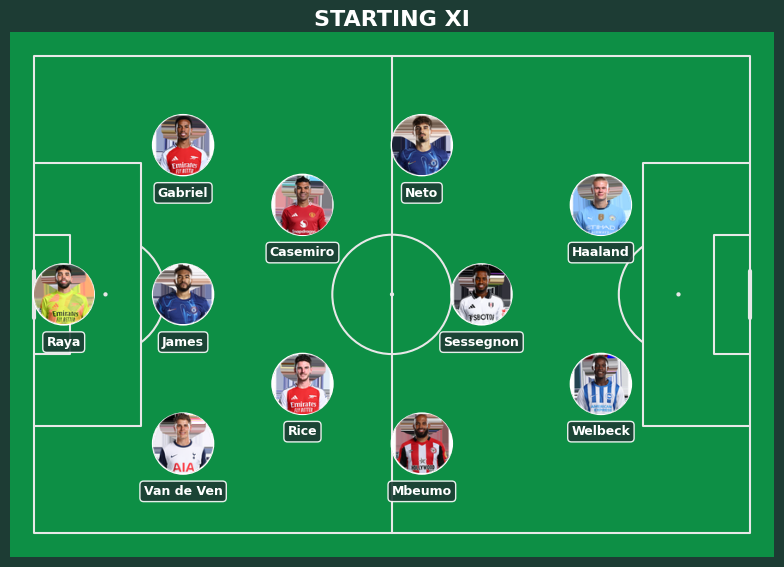

In [22]:
!pip install mplsoccer
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
from io import BytesIO
from PIL import ImageDraw

# --- SPLIT BY POSITION ---
gk = starting_xi[starting_xi['position'] == 'Goalkeeper']
defs = starting_xi[starting_xi['position'] == 'Defender']
mids = starting_xi[starting_xi['position'] == 'Midfielder'].copy()
fwds = starting_xi[starting_xi['position'] == 'Forward']

# --- SWAP RICE & MBEUMO ---
rice_idx = mids.index[mids['player_name'] == 'Rice'][0]
mbeumo_idx = mids.index[mids['player_name'] == 'Mbeumo'][0]
mids.loc[rice_idx], mids.loc[mbeumo_idx] = mids.loc[mbeumo_idx].copy(), mids.loc[rice_idx].copy()
mids = mids.reset_index(drop=True)

# --- CREATE PITCH ---
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d8f45', line_color='#e8e8e8', line_zorder=2, linewidth=1.5)

fig, ax = pitch.draw(figsize=(8, 12))
fig.set_facecolor('#1d3c34')

# --- FORMATION COORDINATES (Vertical 3-5-2) ---
positions = {
    'GK': [(5, 40)],
    'DEF': [(25, 15), (25, 40), (25, 65)],
    'MID': [(45, 25), (45, 55), (65, 65), (65, 15), (75, 40)],
    'FWD': [(95, 25), (95, 55)]
}

# --- PLAYER PHOTO URLS ---
player_photos = {
    'Raya': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p154561.png',
    'Gabriel': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p226597.png',
    'James': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p225796.png',
    'Van de Ven': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p491279.png',
    'Casemiro': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p61256.png',
    'Rice': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p204480.png',
    'Mbeumo': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p446008.png',
    'Neto': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p247632.png',
    'Sessegnon': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p184349.png',
    'Haaland': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p223094.png',
    'Welbeck': 'https://resources.premierleague.com/premierleague/photos/players/250x250/p50175.png'
}

# --- DRAW PLAYER WITH IMAGE ---
def draw_player_with_image(x, y, name, position):
    # Get photo URL
    photo_url = player_photos.get(name)

    if photo_url:
        try:
            # Download and process image
            response = requests.get(photo_url)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGBA")

            # Create circular mask
            size = img.size
            mask = Image.new("L", size, 0)
            mask_draw = ImageDraw.Draw(mask)
            mask_draw.ellipse((0, 0, size[0], size[1]), fill=255)

            # Apply circular mask
            img.putalpha(mask)

            # Resize image
            img = img.resize((70, 70), Image.LANCZOS)

            # Convert to numpy array for matplotlib
            img_array = np.array(img)

            img_array = np.flipud(img_array)

            # Display circular image
            ax.imshow(img_array, extent=[x-5, x+5, y-5, y+5], zorder=4)

            # Add white border circle
            circle = plt.Circle((x, y), 5, fill=False, edgecolor='white', linewidth=2, zorder=3)
            ax.add_patch(circle)

        except Exception as e:
            print(f"Error loading image for {name}: {e}")
            # Fallback to colored circle
            draw_fallback_circle(x, y, name, position)
    else:
        # Fallback if no URL found
        draw_fallback_circle(x, y, name, position)

    # Player Name label with background
    ax.text(x, y+8, name, ha='center', va='center', fontsize=9, color='white',
            weight='bold', zorder=6,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='#1d3c34',
                     edgecolor='white', alpha=0.9, linewidth=1))

# --- PLOT PLAYERS WITH IMAGES ---
# GK
if len(gk) > 0:
    row = gk.iloc[0]
    draw_player_with_image(*positions['GK'][0], row['player_name'], row['position'])

# DEF
for i, (_, row) in enumerate(defs.iterrows()):
    if i < len(positions['DEF']):
        x, y = positions['DEF'][i]
        draw_player_with_image(x, y, row['player_name'], row['position'])

# MID
for i, (_, row) in enumerate(mids.iterrows()):
    if i < len(positions['MID']):
        x, y = positions['MID'][i]
        draw_player_with_image(x, y, row['player_name'], row['position'])

# FWD
for i, (_, row) in enumerate(fwds.iterrows()):
    if i < len(positions['FWD']):
        x, y = positions['FWD'][i]
        draw_player_with_image(x, y, row['player_name'], row['position'])

# --- TITLE ---
ax.text(60, -6, 'STARTING XI', ha='center', va='center',
        fontsize=16, weight='bold', color='white')

plt.tight_layout()
plt.show()